In [79]:
import numpy as np
import sklearn.datasets
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [48]:
SEED = 339

In [49]:
dfData, dfTarget = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)
dfData.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


Text(0.5, 0, 'HbA1c')

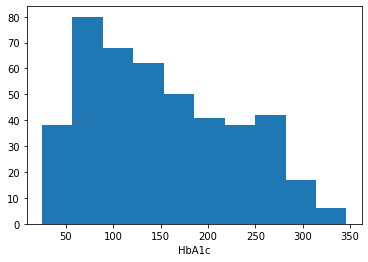

In [50]:
plt.hist(dfTarget)
plt.xlabel('HbA1c')

First, train a standard Gradient Boosting model on the original data. This should get around R^2 of 0.23 on test data.

In [51]:
dfDataTrain, dfDataTest, dfTargetTrain, dfTargetTest = train_test_split(dfData, dfTarget, test_size=0.2, random_state=SEED)
print('Training set size', dfDataTrain.shape[0])
print('Test set size', dfDataTest.shape[0])

Training set size 353
Test set size 89


In [78]:
model = Pipeline([('scaler', StandardScaler()),
                  ('imputer', SimpleImputer()),
                  ('gboost', GradientBoostingRegressor(n_estimators=100, max_depth=4, min_samples_split=5, random_state=SEED))])
model.fit(dfDataTrain, dfTargetTrain)                  
dfPredictTrain = model.predict(dfDataTrain)
dfPredictTest = model.predict(dfDataTest)
print('Train RMSE: {:.3f}, R^2: {:.3f}'.format(mean_squared_error(dfTargetTrain, dfPredictTrain)**0.5, r2_score(dfTargetTrain, dfPredictTrain)))
fTestR2 = r2_score(dfTargetTest, dfPredictTest)
print('Test RMSE: {:.3f}, R^2: {:.3f}'.format(mean_squared_error(dfTargetTest, dfPredictTest)**0.5, fTestR2))

Train RMSE: 19.658, R^2: 0.936
Test RMSE: 64.056, R^2: 0.235


Plot feature importance based on MDI criterion from the Gradient Boosting model

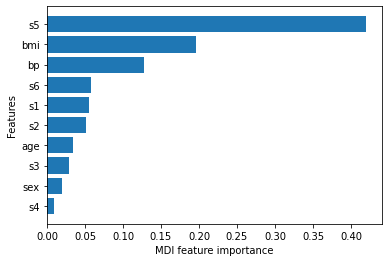

In [53]:
arrFeatureImportance = model.named_steps['gboost'].feature_importances_
arrFeatureOrder = np.argsort(arrFeatureImportance)
plt.barh(np.arange(dfData.shape[1]), arrFeatureImportance[arrFeatureOrder])
plt.yticks(np.arange(dfData.shape[1]), dfData.columns[arrFeatureOrder])
plt.xlabel('MDI feature importance')
plt.ylabel('Features')
plt.show()

Let's create some artificial clusters in the data and add some random slopes to the variable s5, as well as random intercepts.

In [65]:
def add_random_effects(nClusters, fSlopeVariance, fIntVariance, plot=False):
    arrClusters = np.random.randint(0, nClusters, size=(dfTarget.shape))
    # Add a random slope for s5 for each cluster. Draw from normal distribution with mean zero and specified variance
    np.random.seed(SEED)
    arrClusterSlopes = np.random.randn(nClusters) * fSlopeVariance
    arrRandomSlopes = np.vectorize(lambda x: arrClusterSlopes[x])(arrClusters)
    dfTargetRE = dfTarget.copy()
    dfTargetRE += dfData['s5'] * arrRandomSlopes

    if plot:
        # plot the distribution of changes to the target
        plt.hist(dfTargetRE - dfTarget)
        plt.xlabel('Change in HbA1c with added random slope')
        plt.show()

    # Add a random interecept for each cluster
    np.random.seed(SEED)
    arrClusterInts = np.random.randn(nClusters) * fIntVariance
    arrRandomInts = np.vectorize(lambda x: arrClusterInts[x])(arrClusters)
    dfTargetRE += arrRandomInts

    if plot:
        # plot the distribution of changes to the target
        plt.hist(dfTargetRE - dfTarget)
        plt.xlabel('Change in HbA1c with added random intercept')
        plt.show()
    
    return dfTargetRE


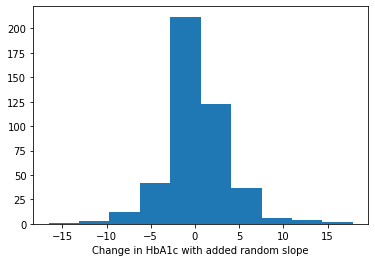

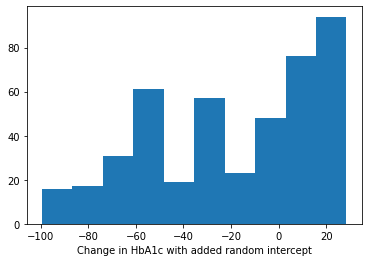

Train RMSE: 21.466, R^2: 0.939
Test RMSE: 77.978, R^2: 0.071


In [67]:
dfTargetRE = add_random_effects(nClusters=10, fSlopeVariance=100, fIntVariance=50, plot=True)

dfDataTrain, dfDataTest, dfTargetRETrain, dfTargetRETest = train_test_split(dfData, dfTargetRE, test_size=0.2, random_state=SEED)
model = Pipeline([('scaler', StandardScaler()),
                  ('imputer', SimpleImputer()),
                  ('gboost', GradientBoostingRegressor(n_estimators=100, max_depth=4, min_samples_split=5, random_state=SEED))])
model.fit(dfDataTrain, dfTargetRETrain)                  
dfPredictTrain = model.predict(dfDataTrain)
dfPredictTest = model.predict(dfDataTest)
print('Train RMSE: {:.3f}, R^2: {:.3f}'.format(mean_squared_error(dfTargetRETrain, dfPredictTrain)**0.5, r2_score(dfTargetRETrain, dfPredictTrain)))
print('Test RMSE: {:.3f}, R^2: {:.3f}'.format(mean_squared_error(dfTargetRETest, dfPredictTest)**0.5, r2_score(dfTargetRETest, dfPredictTest)))

Let's do a grid search over various random effect strengths and cluster numbers and measure the impact on performance

In [76]:
arrSlopeVariance = np.linspace(0, 200, 20)
arrIntVariance = np.linspace(0, 200, 20)
arrClusterNumber = np.arange(3, 10)

dfR2 = pd.DataFrame(columns=['Slope s.d.', 'Int s.d.', 'Clusters', 'R^2'])
iRow = 0

pbar = tqdm(total=arrSlopeVariance.shape[0] * arrIntVariance.shape[0] * arrClusterNumber.shape[0])
for i, fSlope in enumerate(arrSlopeVariance):
    for j, fInt in enumerate(arrIntVariance):
        for k, nClusters in enumerate(arrClusterNumber):
            dfTargetRE = add_random_effects(nClusters, fSlope, fInt)
            dfDataTrain, dfDataTest, dfTargetRETrain, dfTargetRETest = train_test_split(dfData, dfTargetRE, test_size=0.2, random_state=SEED)
            model.fit(dfDataTrain, dfTargetRETrain)                  
            dfPredictTest = model.predict(dfDataTest)
            dfR2.loc[iRow] = [fSlope, fInt, nClusters, r2_score(dfTargetRETest, dfPredictTest)]
            iRow += 1
            pbar.update(1)
pbar.close()

100%|██████████| 2800/2800 [03:51<00:00, 12.10it/s]


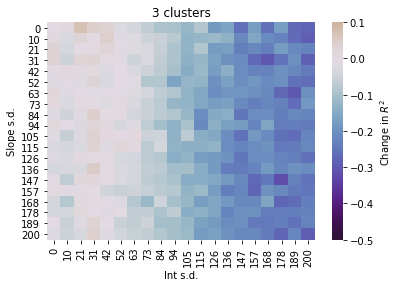

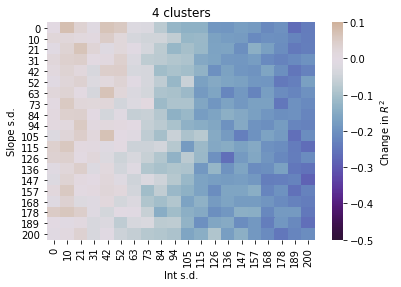

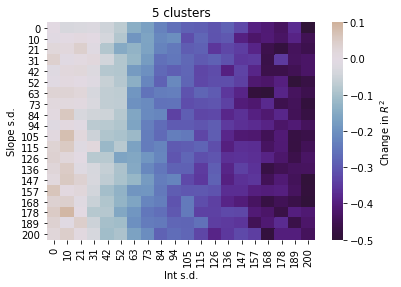

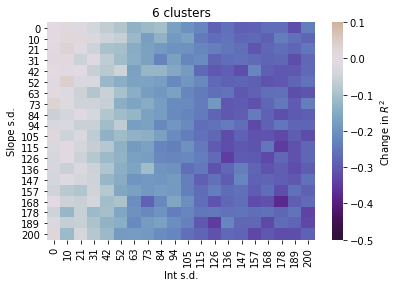

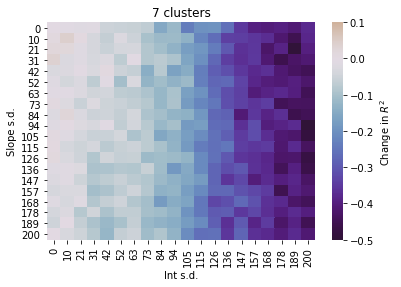

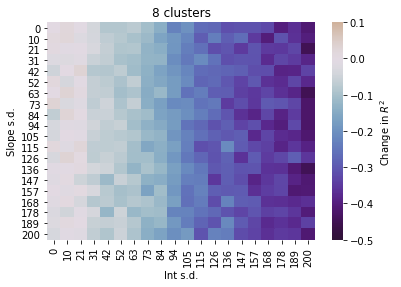

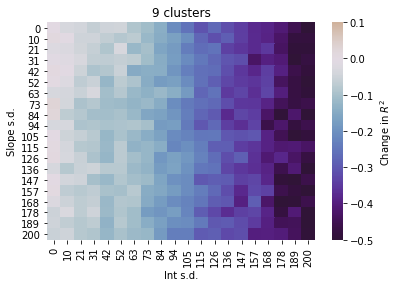

In [122]:
for nClusters in arrClusterNumber:
    dfR2Wide = dfR2.loc[dfR2['Clusters'] == nClusters].pivot(index='Slope s.d.', columns='Int s.d.', values='R^2')
    lsYLabels = [str(int(x)) for x in dfR2Wide.index]
    lsXLabels = [str(int(x)) for x in dfR2Wide.columns]
    sns.heatmap(data=dfR2Wide - fTestR2, cmap='twilight_shifted', vmin=-0.5, vmax=0.1, center=0, xticklabels=lsXLabels, yticklabels=lsYLabels, cbar_kws={'label': 'Change in $R^2$'})
    plt.title('{} clusters'.format(nClusters))
    plt.show()

Using a nonlinear random effect likely has a bigger impact. Let's try a quadratic, random_slope * s5^2

In [103]:
def add_random_effects_quad(nClusters, fSlopeVariance, fIntVariance, plot=False):
    arrClusters = np.random.randint(0, nClusters, size=(dfTarget.shape))
    # Add a random slope for s5 for each cluster. Draw from normal distribution with mean zero and specified variance
    np.random.seed(SEED)
    arrClusterSlopes = np.random.randn(nClusters) * fSlopeVariance
    arrRandomSlopes = np.vectorize(lambda x: arrClusterSlopes[x])(arrClusters)
    dfTargetRE = dfTarget.copy()
    dfTargetRE += dfData['s5']**2 * arrRandomSlopes

    if plot:
        # plot the distribution of changes to the target
        plt.hist(dfTargetRE - dfTarget)
        plt.xlabel('Change in HbA1c with added random slope')
        plt.show()

    # Add a random interecept for each cluster
    np.random.seed(SEED)
    arrClusterInts = np.random.randn(nClusters) * fIntVariance
    arrRandomInts = np.vectorize(lambda x: arrClusterInts[x])(arrClusters)
    dfTargetRE += arrRandomInts

    if plot:
        # plot the distribution of changes to the target
        plt.hist(dfTargetRE - dfTarget)
        plt.xlabel('Change in HbA1c with added random intercept')
        plt.show()
    
    return dfTargetRE


In [104]:
arrSlopeVariance = np.linspace(0, 200, 20)
arrIntVariance = np.linspace(0, 200, 20)
arrClusterNumber = np.arange(3, 10)

dfR2Quad = pd.DataFrame(columns=['Slope s.d.', 'Int s.d.', 'Clusters', 'R^2'])
iRow = 0

pbar = tqdm(total=arrSlopeVariance.shape[0] * arrIntVariance.shape[0] * arrClusterNumber.shape[0])
for i, fSlope in enumerate(arrSlopeVariance):
    for j, fInt in enumerate(arrIntVariance):
        for k, nClusters in enumerate(arrClusterNumber):
            dfTargetRE = add_random_effects_quad(nClusters, fSlope, fInt)
            dfDataTrain, dfDataTest, dfTargetRETrain, dfTargetRETest = train_test_split(dfData, dfTargetRE, test_size=0.2, random_state=SEED)
            model.fit(dfDataTrain, dfTargetRETrain)                  
            dfPredictTest = model.predict(dfDataTest)
            dfR2Quad.loc[iRow] = [fSlope, fInt, nClusters, r2_score(dfTargetRETest, dfPredictTest)]
            iRow += 1
            pbar.update(1)
pbar.close()

100%|██████████| 2800/2800 [03:54<00:00, 11.92it/s]


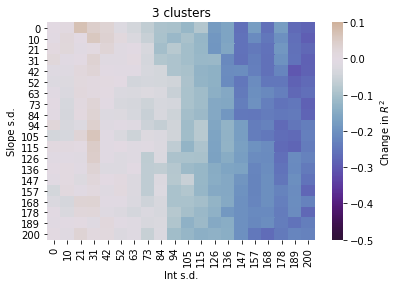

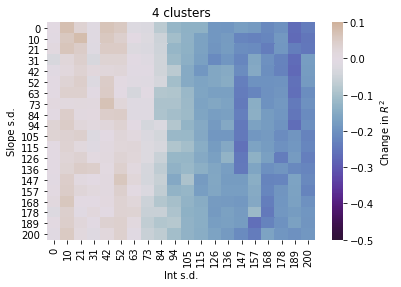

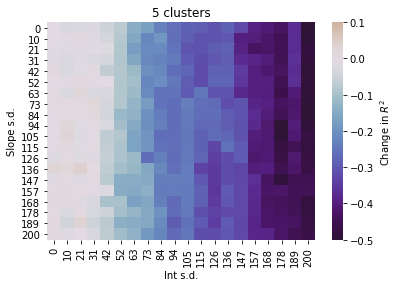

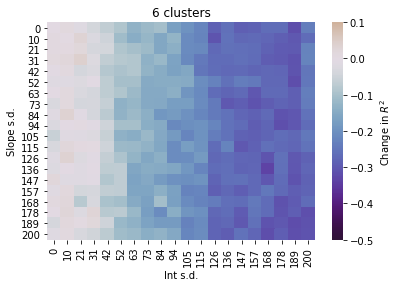

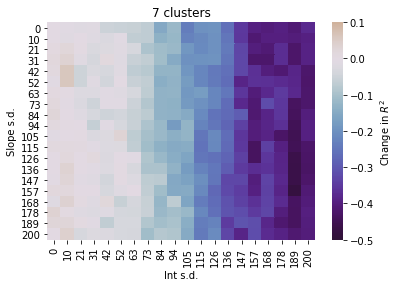

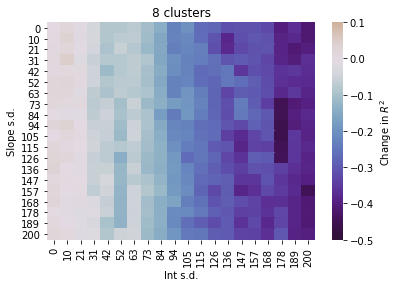

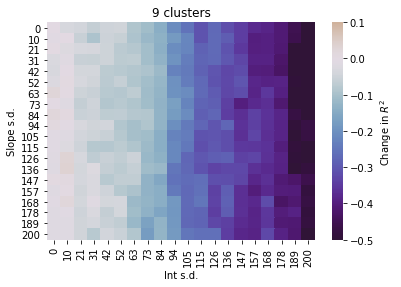

In [123]:
for nClusters in arrClusterNumber:
    dfR2Wide = dfR2Quad.loc[dfR2['Clusters'] == nClusters].pivot(index='Slope s.d.', columns='Int s.d.', values='R^2')
    lsYLabels = [str(int(x)) for x in dfR2Wide.index]
    lsXLabels = [str(int(x)) for x in dfR2Wide.columns]
    sns.heatmap(data=dfR2Wide - fTestR2, cmap='twilight_shifted', vmin=-0.5, vmax=0.1, center=0, xticklabels=lsXLabels, yticklabels=lsYLabels, cbar_kws={'label': 'Change in $R^2$'})
    plt.title('{} clusters'.format(nClusters))
    plt.show()

In [116]:
def add_random_effects_log(nClusters, fSlopeVariance, fIntVariance, plot=False):
    arrClusters = np.random.randint(0, nClusters, size=(dfTarget.shape))
    # Add a random slope for s5 for each cluster. Draw from normal distribution with mean zero and specified variance
    np.random.seed(SEED)
    arrClusterSlopes = np.random.randn(nClusters) * fSlopeVariance
    arrRandomSlopes = np.vectorize(lambda x: arrClusterSlopes[x])(arrClusters)
    dfTargetRE = dfTarget.copy()
    dfTargetRE += np.log(dfData['s5'] + 1) * arrRandomSlopes

    if plot:
        # plot the distribution of changes to the target
        plt.hist(dfTargetRE - dfTarget)
        plt.xlabel('Change in HbA1c with added random slope')
        plt.show()

    # Add a random interecept for each cluster
    np.random.seed(SEED)
    arrClusterInts = np.random.randn(nClusters) * fIntVariance
    arrRandomInts = np.vectorize(lambda x: arrClusterInts[x])(arrClusters)
    dfTargetRE += arrRandomInts

    if plot:
        # plot the distribution of changes to the target
        plt.hist(dfTargetRE - dfTarget)
        plt.xlabel('Change in HbA1c with added random intercept')
        plt.show()
    
    return dfTargetRE


In [119]:
arrSlopeVariance = np.linspace(0, 200, 20)
arrIntVariance = np.linspace(0, 200, 20)
arrClusterNumber = np.arange(3, 10)

dfR2Log = pd.DataFrame(columns=['Slope s.d.', 'Int s.d.', 'Clusters', 'R^2'])
iRow = 0

pbar = tqdm(total=arrSlopeVariance.shape[0] * arrIntVariance.shape[0] * arrClusterNumber.shape[0])
for i, fSlope in enumerate(arrSlopeVariance):
    for j, fInt in enumerate(arrIntVariance):
        for k, nClusters in enumerate(arrClusterNumber):
            dfTargetRE = add_random_effects_log(nClusters, fSlope, fInt)
            dfDataTrain, dfDataTest, dfTargetRETrain, dfTargetRETest = train_test_split(dfData, dfTargetRE, test_size=0.2, random_state=SEED)
            model.fit(dfDataTrain, dfTargetRETrain)                  
            dfPredictTest = model.predict(dfDataTest)
            dfR2Log.loc[iRow] = [fSlope, fInt, nClusters, r2_score(dfTargetRETest, dfPredictTest)]
            iRow += 1
            pbar.update(1)
pbar.close()

74/2800 [02:52<00:59, 12.17it/s]
100%|██████████| 2800/2800 [03:53<00:00, 12.00it/s]


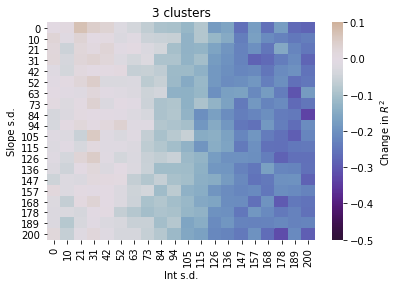

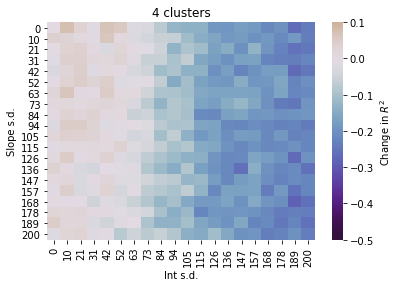

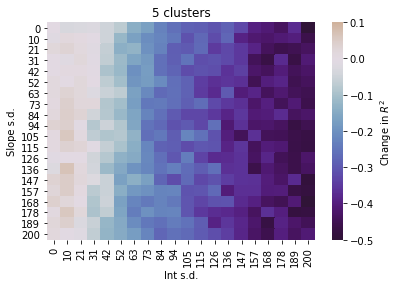

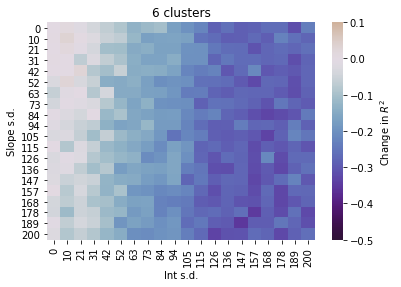

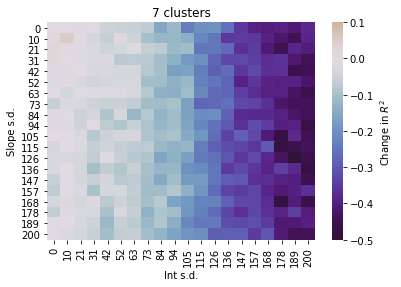

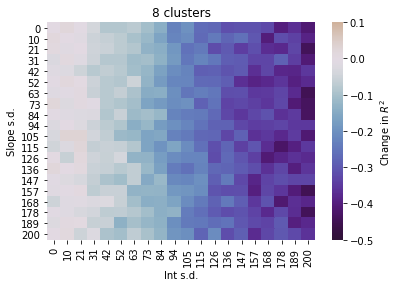

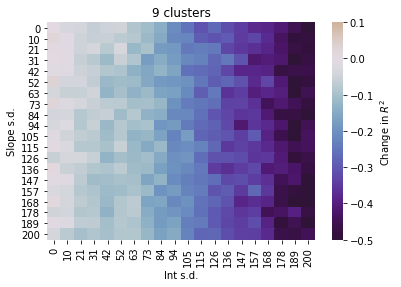

In [124]:
for nClusters in arrClusterNumber:
    dfR2Wide = dfR2Log.loc[dfR2['Clusters'] == nClusters].pivot(index='Slope s.d.', columns='Int s.d.', values='R^2')
    lsYLabels = [str(int(x)) for x in dfR2Wide.index]
    lsXLabels = [str(int(x)) for x in dfR2Wide.columns]
    sns.heatmap(data=dfR2Wide - fTestR2, cmap='twilight_shifted', vmin=-0.5, vmax=0.1, center=0, xticklabels=lsXLabels, yticklabels=lsYLabels, cbar_kws={'label': 'Change in $R^2$'})
    plt.title('{} clusters'.format(nClusters))
    plt.show()